The purpose of this notebook is to test the data augmentation technique from this paper: https://onlinelibrary.wiley.com/doi/full/10.1002/int.23013

The topics for investigation are:
- How effective is this technique at generating new samples for our dataset
- How long does it take to train

In [1]:
import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal.windows import tukey
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
# Loading ex-vivo data
path_to_data = "Data\\Ex-Vivo\\"
files = os.listdir(path_to_data)

# Removing readme
files.remove("READ_ME.txt")

data = []

for file in files:
    with open(path_to_data + file, 'rb') as f:
        data.append(pickle.load(f))

# sorting data based on date

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])


# Fixing labeling errors

data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days

for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix


# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

# Creating sample ID as separate field in data dict
for d in data:
    d['sample_id'] = d['samplematrix_fixed'].split()[1]

In [3]:
# Using only the first forward scan for each sample
for d in data:
    signal = d['scan'][0]['forward_scan']['signal']
    reference = d['ref'][0]['forward_scan']['signal']
    signal = np.array(signal)
    reference = np.array(reference)
    d['signal'] = signal
    d['reference'] = reference
    d['time'] = d['scan'][0]['forward_scan']['time']

In [4]:
# Standardizing signal using mean and std and then performing max-min normalization
for d in data:
    d['signal_standardized'] = (d['signal'] - np.mean(d['signal'])) / np.std(d['signal'])
    d['signal_ref_standardized'] = (d['reference'] - np.mean(d['reference'])) / np.std(d['reference'])

    d['signal_normalized'] = (d['signal_standardized'] - np.min(d['signal_standardized'])) / (np.max(d['signal_standardized']) - np.min(d['signal_standardized']))
    d['signal_ref_normalized'] = (d['signal_ref_standardized'] - np.min(d['signal_ref_standardized'])) / (np.max(d['signal_ref_standardized']) - np.min(d['signal_ref_standardized']))

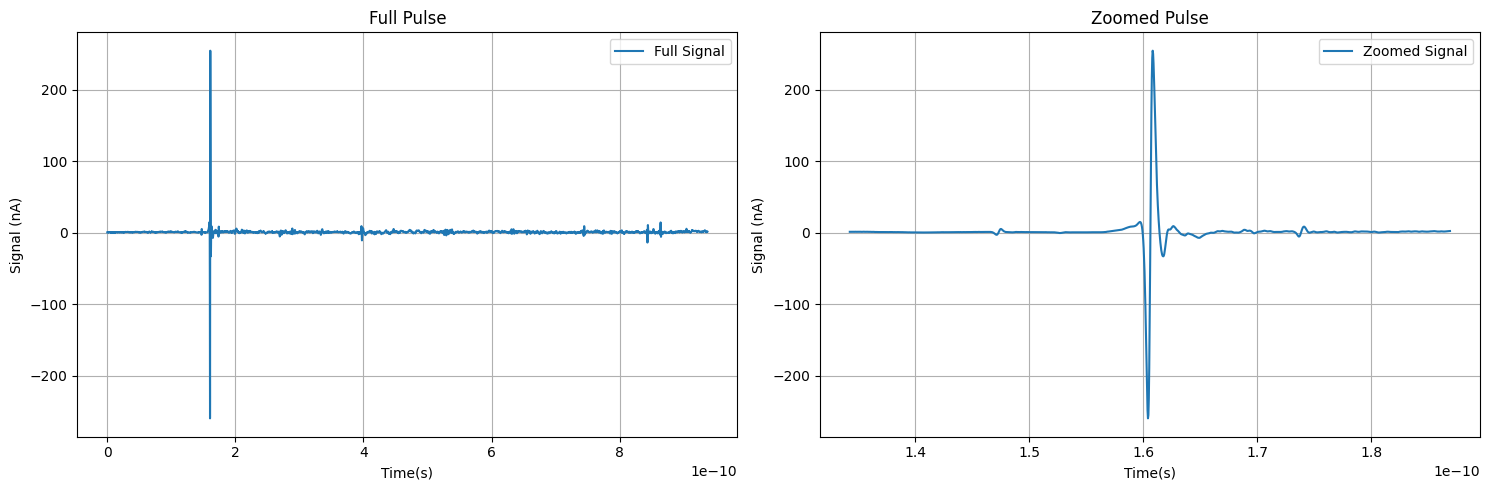

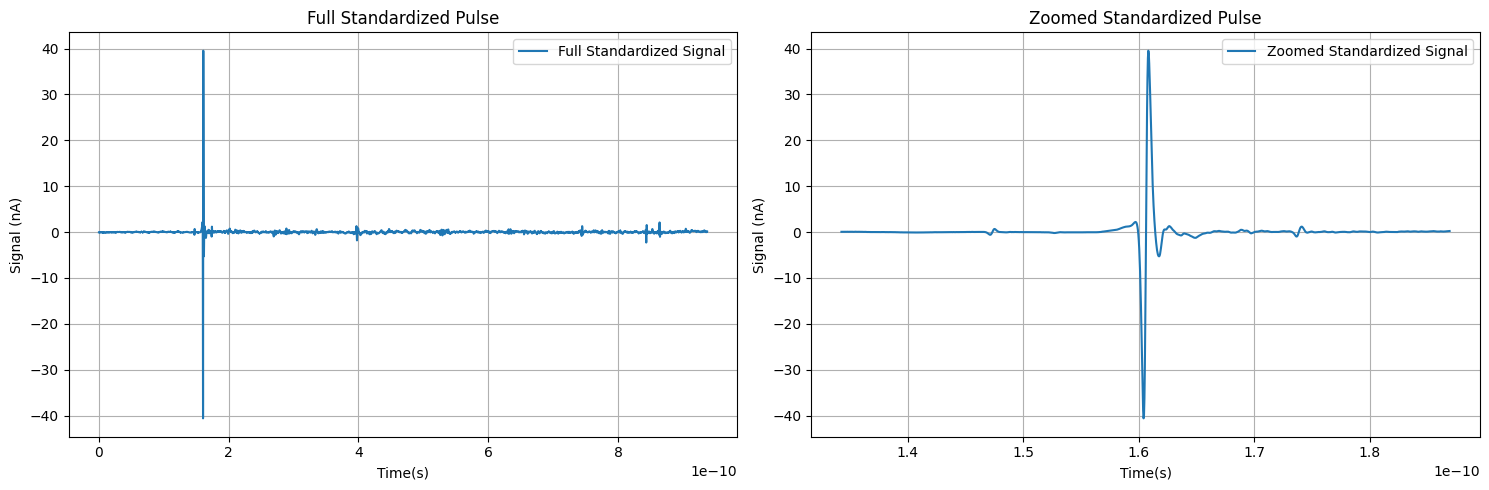

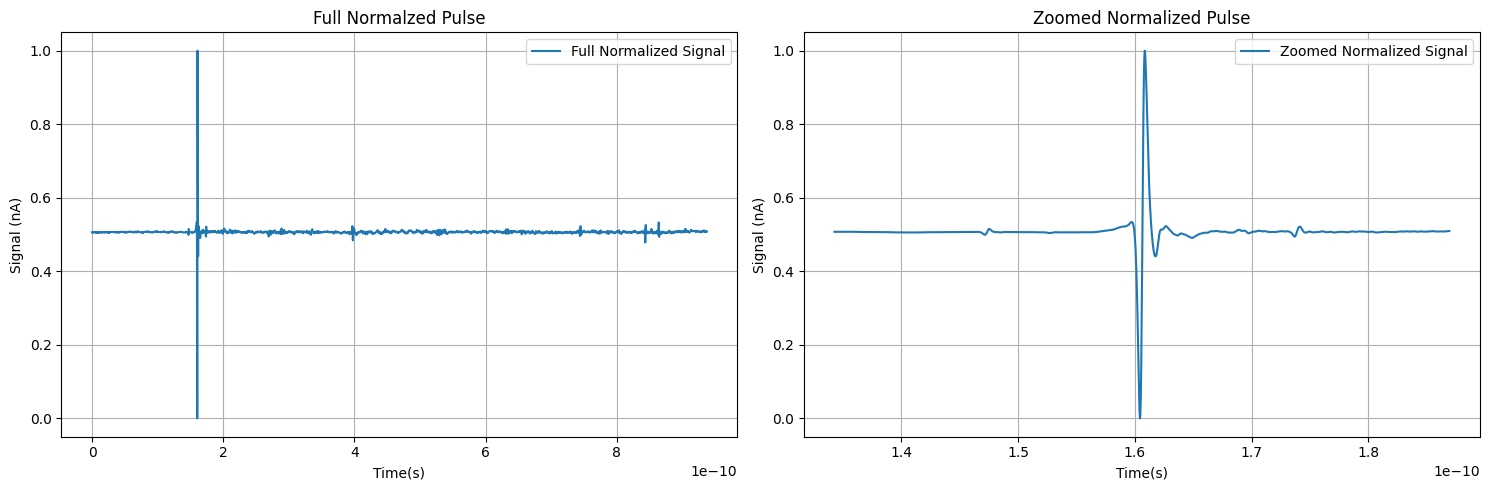

In [5]:
# Plotting normal signal
x = data[0]['time']
y = data[0]['signal']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Plotting standardized signal
x = data[0]['time']
y = data[0]['signal_standardized']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Standardized Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Standardized Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Standardized Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Standardized Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Plotting normalized signal
x = data[0]['time']
y = data[0]['signal_normalized']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Normalized Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Normalzed Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Normalized Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Normalized Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Subtracting reference signal from signal
for d in data:
    d['signal_subtracted'] = d['signal_normalized'] - d['signal_ref_normalized']

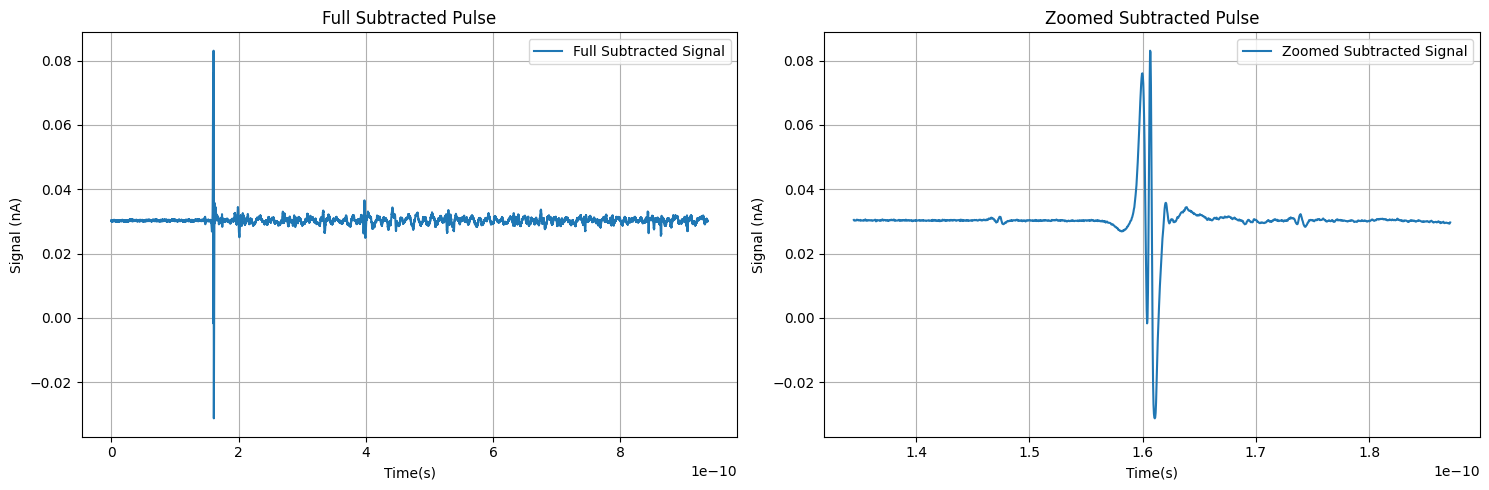

In [7]:
# Plotting subtracted signal
x = data[0]['time']
y = data[0]['signal_subtracted']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Subtracted Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Subtracted Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Subtracted Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Subtracted Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Subtracting bare samples from treated samples
bare_data = [d for d in data if 'bare' in d['samplematrix_fixed']]
treated_data = [d for d in data if not 'bare' in d['samplematrix_fixed']]

for t in treated_data:
    corresponding_bare = [b for b in bare_data if b['sample_id'] == t['sample_id']][0]
    t['signal_final'] = t['signal_subtracted'] - corresponding_bare['signal_subtracted']

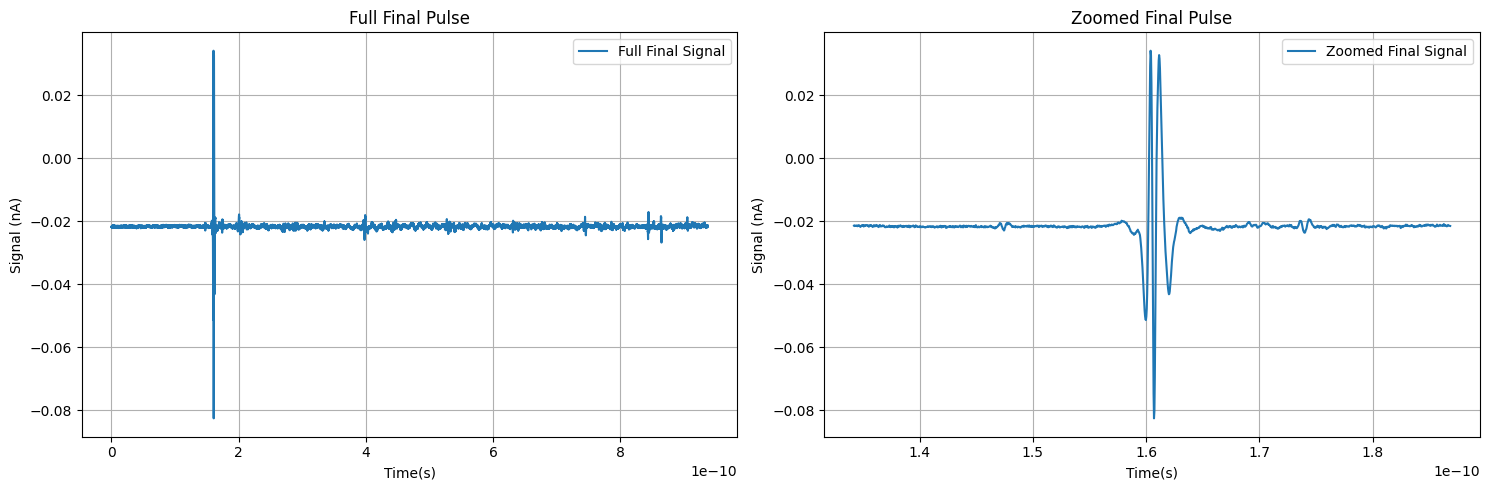

In [9]:
# Plotting final signal
x = treated_data[0]['time']
y = treated_data[0]['signal_final']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Final Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Final Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# find average index for the middle of the big pulse

locations = []

for d in treated_data:
    min_index = np.argmin(d['signal_final'])
    max_index = np.argmax(d['signal_final'])
    middle_index = math.floor((min_index + max_index) / 2)
    locations.append(middle_index)

average_location = math.floor(np.mean(locations))

print("Average location of the pulse: ", average_location)
print("Standard deviation of the location of the pulse: ", np.std(locations))
print("Max distance from average location: ", np.max(np.abs(np.array(locations) - average_location)))

Average location of the pulse:  4294
Standard deviation of the location of the pulse:  20.136042989443762
Max distance from average location:  34


In [11]:
# We must hardcode these values
# Before we based it on the middle of the big pulse and then went 1000 samples to the left and 1000 samples to the right
# Problem with this is that the pulse would be perfectly centered in the middle of the window
# This means that we lose information about the offset of the pulse
# By hardcoding the values the big pulse will not be perfectly centered in the window

window_start = 3750
window_end = 4850


for d in treated_data:
    d['signal_final_cut'] = d['signal_final'][window_start: window_end]
    d['time_cut'] = d['time'][window_start: window_end]


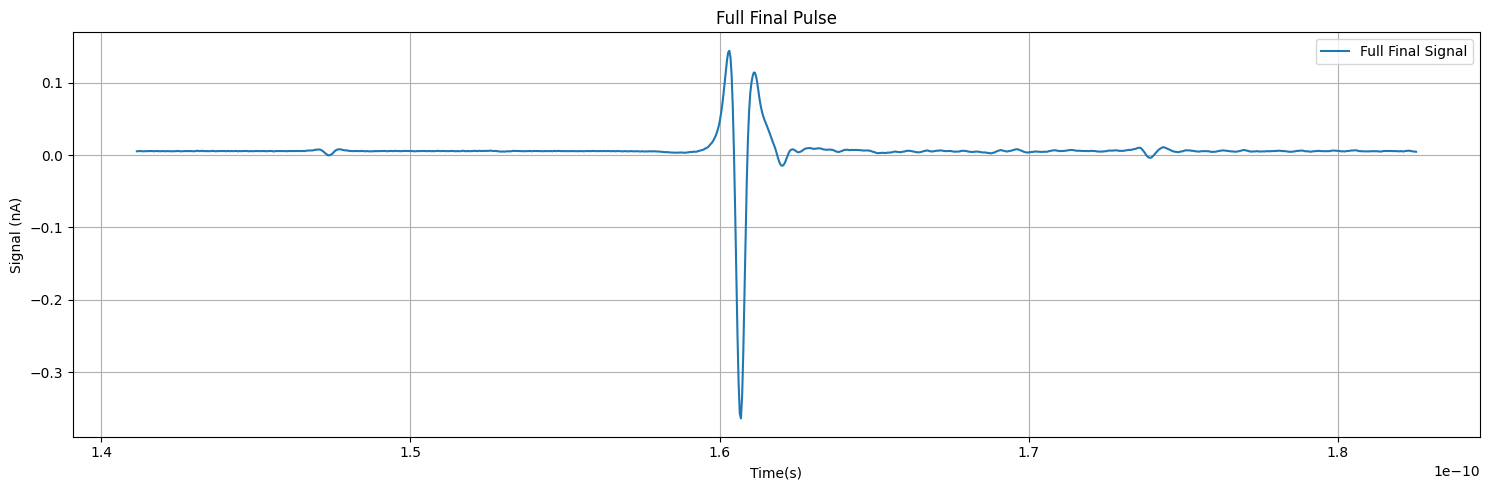

In [12]:
# Plotting final cut signal
x = treated_data[1]['time_cut']
y = treated_data[1]['signal_final_cut']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.plot(x, y, label='Full Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Final Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Creating the dataset
time = treated_data[0]['time_cut']
X = []
Y = []

for t in treated_data:
    X.append(t['signal_final_cut'])
    Y.append(t['samplematrix_fixed'].split()[2])

X = np.array(X)
Y = np.array(Y)

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

# encoding the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(Y)

print("y values first 10: ", Y[:10])
print("distinct y values: ", np.unique(Y))

X shape:  (44, 1100)
Y shape:  (44,)
y values first 10:  [0 0 0 1 1 1 1 0 0 1]
distinct y values:  [0 1]


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, multiply, ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop

In [38]:
def build_generator(latent_dim, num_classes, num_features):
    # Input layers
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')

    # Label embedding and multiplication
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])

    # Dense layers
    x = Dense(256)(model_input)
    x = Activation('tanh')(x)
    
    x = Dense(128)(x)
    x = Activation('tanh')(x)

    x = Dense(128)(x)
    x = Activation('tanh')(x)

    x = Dense(128)(x)
    x = Activation('tanh')(x)
    
    output = Dense(num_features)(x)
    
    # Create the model
    model = Model([noise, label], output)
    
    return model


def build_discriminator(input_dim, num_classes):
    # Input layer
    data = Input(shape=(input_dim,))

    # Dense layers with ReLU activations as per the diagram
    x = Dense(256)(data)
    x = ReLU()(x)
    
    x = Dense(128)(x)
    x = ReLU()(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    
    # Fork into two branches
    # Branch 1: Classification
    classification = Dense(num_classes, activation='softmax')(x)

    # Branch 2: Real/Fake discrimination
    discrimination = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(data, [classification, discrimination])
    
    return model


def compile_models(generator, discriminator, latent_dim, learning_rate):
    optimizer = RMSprop(learning_rate=learning_rate)

    discriminator.compile(loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
                          optimizer=optimizer,
                          metrics=['sparse_categorical_accuracy', 'accuracy'])

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    pulse = generator([noise, label])

    discriminator.trainable = False
    target_label, is_valid = discriminator(pulse)

    combined = Model([noise, label], [is_valid, target_label])
    combined.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
                     optimizer=optimizer)
    
    return combined


# This is taken from keras' website
def gradient_penalty(discriminator, batch_size, real_pulses, fake_pulses):
    """Calculates the gradient penalty for pulse data.

    This loss is calculated on an interpolated pulse
    and added to the discriminator loss.
    """
    # Get the interpolated pulse
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = fake_pulses - real_pulses
    interpolated = real_pulses + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated pulse.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated pulse.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [42]:
def train(generator, discriminator, combined, epochs, batch_size, latent_dim, num_classes, X_train, y_train, lambda_gp=10.0):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        pulses, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, (batch_size, 1))
        gen_pulses = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch(pulses, [labels, valid])
        d_loss_fake = discriminator.train_on_batch(gen_pulses, [gen_labels, fake])

        gp = gradient_penalty(discriminator, batch_size, pulses, gen_pulses)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) + lambda_gp * gp

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, (batch_size, 1))
        g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        # Print progress
        print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss} | D real class accuracy: {100 * d_loss_real[1]:.2f}% | D fake class accuracy: {100 * d_loss_fake[1]:.2f}%] [G loss: {g_loss[0]}]")

        # Save generated images periodically
        if (epoch + 1) % 100 == 0:
            save_pulses(generator, epoch + 1, latent_dim, num_classes)

def save_pulses(generator, epoch, latent_dim, num_classes):
    # Number of samples to generate
    num_samples = 3
    
    # Generate noise and random labels
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    sampled_labels = np.array([i % num_classes for i in range(num_samples)]).reshape(-1, 1)
    
    # Generate pulses
    gen_pulses = generator.predict([noise, sampled_labels])

    for i, pulse in enumerate(gen_pulses):
        # Plotting final cut signal
        x = treated_data[0]['time_cut']
        y = pulse

        plt.figure(figsize=(15, 5))

        plt.plot(x, y, label='Generated Signal')
        plt.xlabel("Time(s)")
        plt.ylabel("Signal (nA)")
        plt.title("Generated Signal")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        if not os.path.exists(f"generated/epoch_{epoch}"):
            os.makedirs(f"generated/epoch_{epoch}")
        plt.savefig(f"generated/epoch_{epoch}/{i+1}.png")
        plt.close()
    
    print(f"Generated pulses saved to generated/{epoch} folder")

def pretrain_discriminator(discriminator, X_train, y_train, batch_size, latent_dim, num_classes, pretrain_steps, lambda_gp=10.0): # lambda_gp = 10 is suggested in the wgan-gp paper
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for step in range(pretrain_steps):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        pulses, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, (batch_size, 1))
        gen_pulses = generator.predict([noise, gen_labels])

        d_loss_real = discriminator.train_on_batch(pulses, [labels, valid])
        d_loss_fake = discriminator.train_on_batch(gen_pulses, [gen_labels, fake])

        gp = gradient_penalty(discriminator, batch_size, pulses, gen_pulses)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) + lambda_gp * gp

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print(f"Pretraining Step {step + 1}/{pretrain_steps} [D loss: {d_loss} | D real class accuracy: {100 * d_loss_real[1]:.2f}% | D fake class accuracy: {100 * d_loss_fake[1]:.2f}%]")

# Parameters
latent_dim = 100  # Size of the noise vector
num_classes = 2   # Number of classes (0 or 1)
num_features = 1100  # Number of features in the dataset
epochs = 1000
batch_size = 10
pretrain_steps = 10
learning_rate = 0.0001

# Create the generator and discriminator
generator = build_generator(latent_dim, num_classes, num_features)
discriminator = build_discriminator(num_features, num_classes)
combined = compile_models(generator, discriminator, latent_dim, learning_rate)

# Pretrain the discriminator
pretrain_discriminator(discriminator, X, Y, batch_size, latent_dim, num_classes, pretrain_steps)

# Train the ACGAN
train(generator, discriminator, combined, epochs, batch_size, latent_dim, num_classes, X, Y)

generator.save('models/generator_model.h5')
discriminator.save('models/discriminator_model.h5')
combined.save('models/combined_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


c:\Users\asama\Anaconda3\envs\master_thesis\lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Pretraining Step 1/10 [D loss: [1.401439 0.5      0.25    ] | D real class accuracy: 40.00% | D fake class accuracy: 60.00%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pretraining Step 2/10 [D loss: [1.3945503 0.6166667 0.4166667] | D real class accuracy: 63.33% | D fake class accuracy: 60.00%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pretraining Step 3/10 [D loss: [1.3950222 0.545     0.45     ] | D real class accuracy: 54.00% | D fake class accuracy: 55.00%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Pretraining Step 4/10 [D loss: [1.3925023  0.6        0.46428573] | D real class accuracy: 60.00% | D fake class accuracy: 60.00%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Pretraining Step 5/10 [D loss: [1.3916631 0.595     0.4722222] | D real class accuracy: 60.00% | D fake class accuracy: 59.00%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Pretraining Step 6/10 [D loss: [1.3929892  0.57878786 0.47727275] | D real class accuracy: 59.09% | D fake class accuracy: 56.67%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
P

KeyboardInterrupt: 